In [1]:
%matplotlib inline

import os
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import numpy as np
import rasterio as rio
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import rasterstats

In [3]:
outline = gpd.read_file(os.path.abspath('Data_files/boundaries.dbf'))
urban = gpd.read_file(os.path.abspath('Data_files/urban.dbf'))
settlements = gpd.read_file(os.path.abspath('Data_files/settlements.dbf'))
roads = gpd.read_file(os.path.abspath('Data_files/roads.dbf'))
rivers = gpd.read_file(os.path.abspath('Data_files/rivers.dbf'))
habitats = gpd.read_file(os.path.abspath('Data_files/habitats.dbf'))
nsites = gpd.read_file(os.path.abspath('Data_files/nesting.dbf'))

<GeoAxes: >

C:\Users\M533\anaconda3\envs\project\Lib\site-packages\cartopy\mpl\feature_artist.py:173: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')
C:\Users\M533\anaconda3\envs\project\Lib\site-packages\cartopy\mpl\feature_artist.py:173: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')
C:\Users\M533\anaconda3\envs\project\Lib\site-packages\cartopy\mpl\feature_artist.py:173: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')


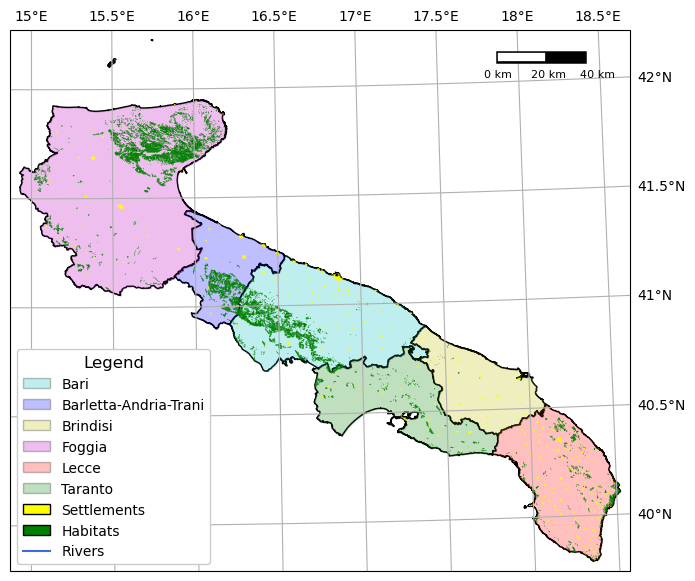

In [4]:
# generate matplotlib handles to create a legend of each of the features we put in our map.
def generate_handles(labels, colors, edge='k', alpha=1):
    lc = len(colors)  # get the length of the color list
    handles = [] # create an empty list
    for ii in range(len(labels)): # for each label and color pair that we're given, make an empty box to pass to our legend
        handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[ii % lc], edgecolor=edge, alpha=alpha))
    return handles

# create a scale bar of length 20 km in the upper right corner of the map
# adapted this question: https://stackoverflow.com/q/32333870
# answered by SO user Siyh: https://stackoverflow.com/a/35705477
def scale_bar(ax, location=(0.92, 0.95)):
    x0, x1, y0, y1 = ax.get_extent() # get the current extent of the axis
    sbx = x0 + (x1 - x0) * location[0] # get the lower left x coordinate of the scale bar
    sby = y0 + (y1 - y0) * location[1] # get the lower left y coordinate of the scale bar

    ax.plot([sbx, sbx - 40000], [sby, sby], color='k', linewidth=9, transform=ax.projection) # plot a thick black line, 20 km long
    ax.plot([sbx, sbx - 20000], [sby, sby], color='k', linewidth=6, transform=ax.projection) # plot a smaller black line from 0 to 10 km long
    ax.plot([sbx-20000, sbx - 40000], [sby, sby], color='w', linewidth=6, transform=ax.projection) # plot a white line from 10 to 20 km

    ax.text(sbx, sby-10000, '40 km', transform=ax.projection, fontsize=8) # add a label at 20 km
    ax.text(sbx-25000, sby-10000, '20 km', transform=ax.projection, fontsize=8) # add a label at 10 km
    ax.text(sbx-49000, sby-10000, '0 km', transform=ax.projection, fontsize=8) # add a label at 0 km

    return ax

ni_utm = ccrs.UTM(33)  # create a Universal Transverse Mercator reference system to transform our data.
ccrs.CRS(outline.crs)

myFig = plt.figure(figsize=(8, 8))  # create a figure of size 8x8 (representing the page size in inches)
ax = plt.axes(projection=ni_utm)  # create an axes object in the figure, using a UTM projection,
outline_feature = ShapelyFeature(outline['geometry'], ni_utm, edgecolor='k', facecolor='w')
ax.add_feature(outline_feature) # add the features we've created to the map.

xmin, ymin, xmax, ymax = outline.total_bounds # using the boundary of the shapefile features, zoom the map to our area of interest
ax.set_extent([xmin-5000, xmax+5000, ymin-5000, ymax+5000], crs=ni_utm) # because total_bounds gives output as xmin, ymin, xmax, ymax,
# but set_extent takes xmin, xmax, ymin, ymax, we re-order the coordinates here.

prov_colors = ['c', 'b', 'y', 'm', 'r', 'g']

# get a list of unique names for the county boundaries
prov_names = list(outline.NOME_PROV.unique())
prov_names.sort() # sort the counties alphabetically by name

# next, add the municipal outlines to the map using the colors that we've picked.
# here, we're iterating over the unique values in the 'CountyName' field.
# we're also setting the edge color to be black, with a line width of 0.5 pt.
# Feel free to experiment with different colors and line widths.
for ii, name in enumerate(prov_names):
    feat = ShapelyFeature(outline.loc[outline['NOME_PROV'] == name, 'geometry'], # first argument is the geometry
                          ccrs.CRS(outline.crs), # second argument is the CRS
                          edgecolor='k', # outline the feature in black
                          facecolor=prov_colors[ii], # set the face color to the corresponding color from the list
                          linewidth=1, # set the outline width to be 1 pt
                          alpha=0.25) # set the alpha (transparency) to be 0.25 (out of 1)
    ax.add_feature(feat) # once we have created the feature, we have to add it to the map using ax.add_feature()

urban_feat = ShapelyFeature(urban['geometry'], # first argument is the geometry
                            ccrs.CRS(urban.crs), # second argument is the CRS
                            edgecolor='yellow', # set the edgecolor to be yellow
                            facecolor='yellow',
                            linewidth=0.1) # set the outline width to be 1 pt
ax.add_feature(urban_feat) # add the collection of features to the map

habitats_feat = ShapelyFeature(habitats['geometry'], # first argument is the geometry
                            ccrs.CRS(habitats.crs), # second argument is the CRS
                            edgecolor='green', # set the edgecolor to be yellow
                            facecolor='green',
                            linewidth=0.1) # set the outline width to be 1 pt
ax.add_feature(habitats_feat) # add the collection of features to the map

# generate a list of handles for the county datasets
# first, we add the list of names, then the list of colors, and finally we set the transparency
# (since we set it in the map)
outline_handles = generate_handles(outline.NOME_PROV.unique(), prov_colors, alpha=0.25)

# note: if you change the color you use to display lakes, you'll want to change it here, too
urban_handle = generate_handles(['Settlements'], ['yellow'])

# note: if you change the color you use to display rivers, you'll want to change it here, too
habitat_handle = generate_handles(['Habitas'], ['green'])

rivers_handle = [mlines.Line2D([], [], color='royalblue')]

# update county_names to take it out of uppercase text
nice_names = [name.title() for name in prov_names]

# ax.legend() takes a list of handles and a list of labels corresponding to the objects 
# you want to add to the legend
handles = outline_handles + urban_handle + habitat_handle + rivers_handle # use '+' to concatenate (combine) lists
labels = nice_names + ['Settlements', 'Habitats', 'Rivers']

leg = ax.legend(handles, labels, title='Legend', title_fontsize=12, 
                 fontsize=10, loc='lower left', frameon=True, framealpha=1)

gridlines = ax.gridlines(draw_labels=True, # draw  labels for the grid lines
                         xlocs=[15, 15.5, 16, 16.5, 17, 17.5, 18, 18.5], # add longitude lines at 0.5 deg intervals
                         ylocs=[39.5, 40, 40.5, 41, 41.5, 42]) # add latitude lines at 0.5 deg intervals
gridlines.left_labels = False # turn off the left-side labels
gridlines.bottom_labels = False # turn off the bottom labels

scale_bar(ax) # place a scale bar in the upper right corner of the map window

In [5]:
roads_feat = ShapelyFeature(roads['geometry'], # first argument is the geometry
                            ccrs.CRS(roads.crs), # second argument is the CRS
                            edgecolor='grey', # set the edgecolor to be royalblue
                            linewidth=0.2) # set the linewidth to be 0.2 pt
ax.add_feature(roads_feat) # add the collection of features to the map
myFig

C:\Users\M533\anaconda3\envs\project\Lib\site-packages\cartopy\mpl\feature_artist.py:173: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')


TypeError: cannot create weak reference to 'NoneType' object

<Figure size 800x800 with 1 Axes>